In [1]:
# Import Libraries 

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from tqdm import tqdm
import cv2
%load_ext tensorboard
import datetime
import random

In [2]:
tp_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
gt_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/CASIA 2 Groundtruth'

tp_data = {'image_id': [],'image_path': [],'label': []}
gt_data = {'image_id': [],'mask_image_path': []}


for img in os.listdir(tp_path):
    if img.endswith('jpg') or img.endswith('png'):
        temp_path = os.path.join(tp_path, img)
        tp_data['image_path'].append(temp_path)
        tp_data['label'].append('fake')
        tp_data['image_id'].append(img[:-4])
    
for img in os.listdir(gt_path):
    temp_path = os.path.join(gt_path, img)
    gt_data['mask_image_path'].append(temp_path)
    gt_data['image_id'].append(img[:-7])
    
        
tp_data = pd.DataFrame(tp_data)
gt_data = pd.DataFrame(gt_data)

casia_data = pd.merge(tp_data, gt_data, on='image_id')
casia_data = casia_data.sample(frac=1, random_state=random.seed(42)).reset_index(drop=True)
casia_data.head()

,image_id,image_path,label,mask_image_path
0,Tp_S_CNN_M_N_txt00077_txt00077_11296,/kaggle/input/casia-20-image-tampering-detecti...,fake,/kaggle/input/casia-20-image-tampering-detecti...
1,Tp_S_NNN_S_B_nat00081_nat00081_10596,/kaggle/input/casia-20-image-tampering-detecti...,fake,/kaggle/input/casia-20-image-tampering-detecti...
2,Tp_S_CNN_M_N_pla00081_pla00081_10628,/kaggle/input/casia-20-image-tampering-detecti...,fake,/kaggle/input/casia-20-image-tampering-detecti...
3,Tp_D_CRN_S_N_cha10141_cha00086_12234,/kaggle/input/casia-20-image-tampering-detecti...,fake,/kaggle/input/casia-20-image-tampering-detecti...
4,Tp_S_NNN_S_N_cha00008_cha00008_11159,/kaggle/input/casia-20-image-tampering-detecti...,fake,/kaggle/input/casia-20-image-tampering-detecti...


In [3]:
def change_pixel_value(A) :
    if len(A.shape)==3 :
        A=A[:,:,0]
    #Intilize a array B 
    B=np.zeros((A.shape[0],A.shape[1]))
    for i in range(A.shape[0]) :
        for j in range(A.shape[1]) :
            if A[i][j]==255 :
                B[i][j]=0.0 
            else :
                B[i][j]=1.0
    return B

In [5]:
import numpy as np
q = [4.0, 12.0, 2.0]
filter1 = [[0, 0, 0, 0, 0],
           [0, -1, 2, -1, 0],
           [0, 2, -4, 2, 0],
           [0, -1, 2, -1, 0],
           [0, 0, 0, 0, 0]]
filter2 = [[-1, 2, -2, 2, -1],
           [2, -6, 8, -6, 2],
           [-2, 8, -12, 8, -2],
           [2, -6, 8, -6, 2],
           [-1, 2, -2, 2, -1]]
filter3 = [[0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 1, -2, 1, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]]


filter1 = np.asarray(filter1, dtype=float) / q[0]
filter2 = np.asarray(filter2, dtype=float) / q[1]
filter3 = np.asarray(filter3, dtype=float) / q[2]
    
filters = filter1+filter2+filter3

In [5]:
from sklearn.model_selection import train_test_split

train,validation=train_test_split(casia_data,random_state=42,test_size=0.2,stratify=casia_data['label'])

In [6]:
class Dataset:
    def __init__(self, data):
        self.image_path = []
        self.mask_image_path = []
        
        for index,rows in data.iterrows() :
            self.image_path.append(rows['image_path'])
            self.mask_image_path.append(rows['mask_image_path'])
            

    def __getitem__(self, i):
        #Load images 
        img=cv2.imread(self.image_path[i],cv2.IMREAD_UNCHANGED)
        mask_img=cv2.imread(self.mask_image_path[i],0)
        #Converting image to 256,256,3
        #after analyzing i found a single image with 256*256*4
        if img.shape[-1]!=3 :
            img=cv2.resize(img[:,:,:3],(512,512))
        else :
            img=cv2.resize(img,(512,512))
        #Converting mask image into 256*256 
        #We observe some image are 2-d only some are 3-d
        if len(mask_img.shape)==2 :
            mask_img=cv2.resize(mask_img,(512,512))
        else :
            mask_img=cv2.resize(mask_img[:,:,0],(512,512))

        #Processed image 
        preprocess_img=cv2.filter2D(img,-1,filters)
        #process mask image 
        mask_img_mod=change_pixel_value(mask_img)


        
            
        return img,preprocess_img,mask_img_mod
        

    def __len__(self): # your model.fit_gen requires this function
        return len(self.image_path)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset.image_path))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        #batch = [for samples in zip(*data)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        batch[2]=batch[2].reshape((self.batch_size,512,512,1))

        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

train_dataset=Dataset(train)
train_dataloader = Dataloder(train_dataset, batch_size=8,shuffle=True)

test_dataset=Dataset(validation)
test_dataloader = Dataloder(test_dataset, batch_size=8,shuffle=True)

In [7]:
def conv2d_block(input_dim, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same") (input_dim)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

#This part is for input image

input_img = Input((512, 512, 3))
# contracting path
conv11 = conv2d_block(input_img, n_filters=16, kernel_size=3, batchnorm=True)
pool11 = MaxPooling2D((2, 2)) (conv11)
pool11 = Dropout(0.5)(pool11)
conv12 = conv2d_block(pool11, n_filters=32, kernel_size=3, batchnorm=True)
pool12 = MaxPooling2D((2, 2)) (conv12)
pool12 = Dropout(0.5)(pool12)
conv13 = conv2d_block(pool12, n_filters=64, kernel_size=3, batchnorm=True)
pool13 = MaxPooling2D((2, 2)) (conv13)
pool13 = Dropout(0.5)(pool13)
conv14 = conv2d_block(pool13, n_filters=128, kernel_size=3, batchnorm=True)
pool14 = MaxPooling2D(pool_size=(2, 2)) (conv14)
pool14 = Dropout(0.5)(pool14)
conv15 = conv2d_block(pool14, n_filters=256, kernel_size=3, batchnorm=True)
#Expanding path
u6 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same') (conv15)
#skip_connections
u6 = concatenate([u6, conv14])
u6 = Dropout(0.5)(u6)
c6 = conv2d_block(u6, n_filters=128, kernel_size=3, batchnorm=True)
u7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, conv13])
u7 = Dropout(0.5)(u7)
c7 = conv2d_block(u7, n_filters=64, kernel_size=3, batchnorm=True)
u8 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, conv12])
u8 = Dropout(0.5)(u8)
c8 = conv2d_block(u8, n_filters=32, kernel_size=3, batchnorm=True)
u9 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, conv11], axis=3)
u9 = Dropout(0.5)(u9)
c9 = conv2d_block(u9, n_filters=16, kernel_size=3, batchnorm=True)

output = Conv2D(3, (1, 1), activation='sigmoid') (c9)


#This part is for SRM filter output image

input_img_filter = Input((512, 512, 3))

# contracting path
conv21 = conv2d_block(input_img_filter, n_filters=16, kernel_size=3, batchnorm=True)
pool21 = MaxPooling2D((2, 2)) (conv21)
pool21 = Dropout(0.5)(pool21)
conv22 = conv2d_block(pool21, n_filters=32, kernel_size=3, batchnorm=True)
pool22 = MaxPooling2D((2, 2)) (conv22)
pool22 = Dropout(0.5)(pool22)
conv23 = conv2d_block(pool22, n_filters=64, kernel_size=3, batchnorm=True)
pool23 = MaxPooling2D((2, 2)) (conv23)
pool23 = Dropout(0.5)(pool23)
conv24 = conv2d_block(pool23, n_filters=128, kernel_size=3, batchnorm=True)
pool24 = MaxPooling2D(pool_size=(2, 2)) (conv24)
pool24 = Dropout(0.5)(pool24)
conv25 = conv2d_block(pool24, n_filters=256, kernel_size=3, batchnorm=True)
#Expanding path
u6 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same') (conv25)
#skip_connections
u6 = concatenate([u6, conv24])
u6 = Dropout(0.5)(u6)
c6 = conv2d_block(u6, n_filters=128, kernel_size=3, batchnorm=True)
u7 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, conv23])
u7 = Dropout(0.5)(u7)
c7 = conv2d_block(u7, n_filters=64, kernel_size=3, batchnorm=True)
u8 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, conv22])
u8 = Dropout(0.5)(u8)
c8 = conv2d_block(u8, n_filters=32, kernel_size=3, batchnorm=True)
u9 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, conv11], axis=3)
u9 = Dropout(0.5)(u9)
c9 = conv2d_block(u9, n_filters=16, kernel_size=3, batchnorm=True)

output_filter = Conv2D(3, (1, 1), activation='sigmoid') (c9)

combined = concatenate([output, output_filter])
outputs = Conv2D(1, (1, 1), activation='sigmoid') (combined)

model = Model(inputs=[input_img,input_img_filter], outputs=[outputs])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 512, 512, 16)         448       ['input_2[0][0]']             
                                                                                              

In [8]:
import datetime

def scheduler(epoch,lr) :
  if epoch%5==0 :
    lr=0.9*lr
  
  return lr

#Callbacks 
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [2]:
import tensorflow as tf
import keras.backend as K

def iou_score(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [10]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[iou_score])

In [11]:
model.fit_generator(train_dataloader,validation_data=test_dataloader, steps_per_epoch=len(train_dataloader),epochs=20,callbacks=[lrScheduler,tensorboard_callback])

Epoch 1/20


2023-11-29 19:18:25.326337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 1858s 9s/step - loss: 0.5097 - iou_score: 0.5964 - val_loss: 0.4119 - val_iou_score: 0.6722 - lr: 9.0000e-04
Epoch 2/20
200/200 [==============================] - 1787s 9s/step - loss: 0.3499 - iou_score: 0.7377 - val_loss: 0.3594 - val_iou_score: 0.7330 - lr: 9.0000e-04
Epoch 3/20
200/200 [==============================] - 1789s 9s/step - loss: 0.3202 - iou_score: 0.7794 - val_loss: 0.3263 - val_iou_score: 0.7817 - lr: 9.0000e-04
Epoch 4/20
200/200 [==============================] - 1779s 9s/step - loss: 0.3098 - iou_score: 0.7998 - val_loss: 0.3191 - val_iou_score: 0.8040 - lr: 9.0000e-04
Epoch 5/20
200/200 [==============================] - 1786s 9s/step - loss: 0.3061 - iou_score: 0.8074 - val_loss: 0.3170 - val_iou_score: 0.8110 - lr: 9.0000e-04
Epoch 6/20
200/200 [==============================] - 1792s 9s/step - loss: 0.3030 - iou_score: 0.8124 - val_loss: 0.3154 - val_iou_score: 0.8096 - lr: 8.1000e-04
Epoch 7/20
200/200 [=============

In [12]:
model.save('phase2.h5')

In [3]:
from keras.models import load_model


model = load_model('phase2.h5', custom_objects={'iou_score': iou_score})

In [32]:
def predict(img):
    img = cv2.resize(img, (512, 512))
    srm_img = cv2.filter2D(img, -1, filters)
    
    img = np.expand_dims(img, axis=0)
    srm_img = np.expand_dims(srm_img, axis=0)

    prediction = model.predict([img, srm_img])

    prediction = prediction.squeeze()

    for i in range(prediction.shape[0]) :
        for j in range(prediction.shape[1]) :
            if prediction[i][j]>0.75 :
                prediction[i][j]=1.0
            else :
                prediction[i][j]=0.0

    return prediction

1/1 [==============================] - 0s 498ms/step


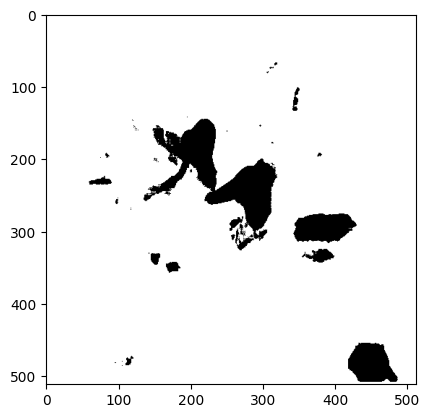

In [33]:
import matplotlib.pyplot as plt

pred = predict(img)

plt.imshow(pred,cmap='gray')